In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from datetime import datetime


In [21]:
# 데이터 불러오기
sales = pd.read_csv('./sales_train.csv')
items = pd.read_csv('./items.csv')
item_categories = pd.read_csv('./item_categories.csv')
shops = pd.read_csv('./shops.csv')
test = pd.read_csv('./test.csv')

In [133]:
samples = pd.read_csv('./sample_submission.csv')

## 1. 전처리

In [11]:
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [12]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [13]:
sales = sales.date.apply(lambda x : datetime.strptime(x,'%d.%m.%Y'))
sales

0         2013-01-02
1         2013-01-03
2         2013-01-05
3         2013-01-06
4         2013-01-15
             ...    
2935844   2015-10-10
2935845   2015-10-09
2935846   2015-10-14
2935847   2015-10-22
2935848   2015-10-03
Name: date, Length: 2935849, dtype: datetime64[ns]

In [14]:
sales.shape # (2935849, 6)

(2935849,)

In [22]:
sales.corr(method = 'pearson') # 상관계수

,date_block_num,shop_id,item_id,item_price,item_cnt_day
date_block_num,1.000000,0.019273,0.009356,0.095010,0.009402
shop_id,0.019273,1.000000,0.029396,-0.024034,-0.005230
item_id,0.009356,0.029396,1.000000,-0.134104,0.016650
item_price,0.095010,-0.024034,-0.134104,1.000000,0.011197
item_cnt_day,0.009402,-0.005230,0.016650,0.011197,1.000000


In [23]:
sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


- 중복데이터 처리

In [24]:
sales = sales.drop_duplicates()
sales.shape  # (2935849, 6) -> (2935843, 6)

(2935843, 6)

- 특정 행 제거

In [25]:
# item_price 가 0 이하인 경우
(sales.item_price <= 0).sum()

1

In [26]:
sales = sales[sales.item_price > 0]

In [27]:
# 팔린 상품의 개수가 (-) 인 경우 -> 행 삭제?, 이전 주문과 함께 삭제
(sales['item_cnt_day'] < 0).sum()

7356

In [28]:
sales = sales[sales.item_cnt_day >= 0]

- 결측치 처리

In [29]:
# 결측치 없음
sales.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

- 이상치 처리

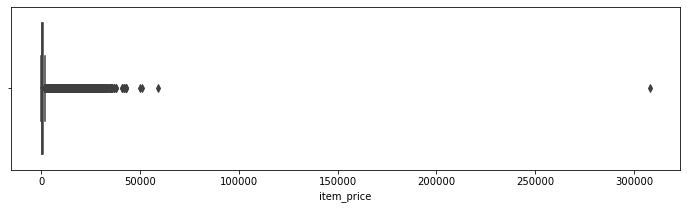

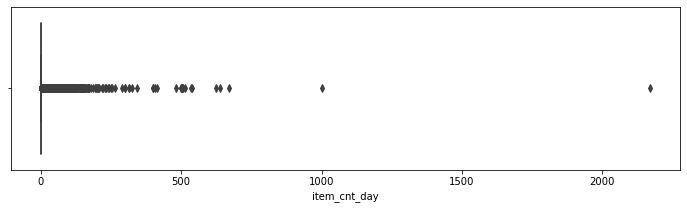

In [30]:
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales)
plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)
plt.show()

In [31]:
# 뚜렷한 이상치를 우선 제거 -> 분석하면서 확인하기
sales = sales[sales.item_cnt_day < 500]
sales = sales[sales.item_price < 50000]

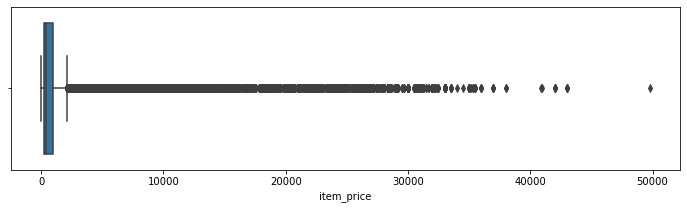

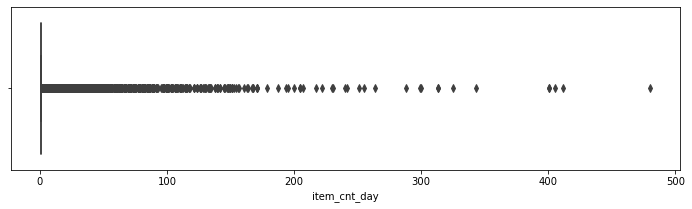

In [32]:
plt.figure(figsize=(12,3))
sns.boxplot(x='item_price', data=sales);
plt.figure(figsize=(12,3))
sns.boxplot(x='item_cnt_day', data=sales)

plt.show()

In [33]:
sales.shape

(2928469, 6)

#### 1. 러시아어 라벨인코딩,  지역 컬럼 만들기
  - item_name
  - item_category_name
  - shop_name
  
#### 2.date, date_block, 가격, 상점id, 상품id, 지역, 월 별 구매 수량 등으로 EDA 분석해보기 -> 추가 컬럼 생각하기

In [83]:
items.head()
item_categories.head()
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [84]:
#shop_name 라벨인코딩
shops.head()
#shops.info()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [85]:
shops['city'] = shops.shop_name.str.split(' ').map(lambda x:x[0])
shops.head() 
#앞부분이 도시 이름인 것 같으니까 띄어쓰기로 split해서
#0번째 아이 데려와서 city 열 추가

#0번째 !Якутск >> 야쿠츠크 (지역 이름)
#2번째 Адыгея >> 아디게야 (지역 이름)

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,!Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,!Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [86]:
#도시가 뭐가 몇 개가 있는지 
shops.city.value_counts()

Москва              13
Тюмень               3
Воронеж              3
РостовНаДону         3
!Якутск              2
Красноярск           2
Якутск               2
Уфа                  2
Самара               2
СПб                  2
Новосибирск          2
Н.Новгород           2
Казань               2
Жуковский            2
Коломна              1
Сургут               1
Балашиха             1
Чехов                1
Цифровой             1
Химки                1
Волжский             1
Вологда              1
Томск                1
Сергиев              1
Курск                1
Выездная             1
Интернет-магазин     1
Омск                 1
Адыгея               1
Мытищи               1
Калуга               1
Ярославль            1
Name: city, dtype: int64

In [88]:
city_encoder = LabelEncoder()
shops['city_code'] = city_encoder.fit_transform(shops.city)
#city_code열 만들어서 도시 fit transform한 거 추가
shops.city_code.value_counts() #개수 맞게 잘 됐나 확인
shops.head()

#shop_name 드롭 (굳이 해야되는 건가?)
shops = shops[['shop_id','city_code']]
shops.head()

,shop_id,city_code
0,0,0
1,1,0
2,2,1
3,3,2
4,4,3


In [75]:
#item_category_name 인코딩
item_categories.head(20)

# Гарнитуры/Наушники >> 헤드셋이나 이어폰같은 건가 봄
#Аксессуары >> 부속품
#Билеты >> 항공권, Цифра >> 숫자
#Доставка товара > 상품배송

#이걸 뭘로 찢어야 되고 뭘 살려야 되는 지 잘 모르겠는데,
#다른 코드 보니까 ' - '로 찢어서 앞에 걸 가져오길래 그렇게 해봄
cate_encoder = LabelEncoder()
item_categories['type'] = item_categories.item_category_name.str.split(' - ').map(lambda x:x[0])
item_categories.head()
#fit_transform
item_categories['type_code'] = cate_encoder.fit_transform(item_categories.type)

In [89]:
item_categories.head()
item_categories = item_categories[['item_category_id','type_code']]
item_categories.head()

,item_category_id,type_code
0,0,0
1,1,1
2,2,1
3,3,1
4,4,1


In [90]:
#item_name 인코딩
items.head()

#ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D > (플랫폼) d에 의해
#***В ЛУЧАХ СЛАВЫ (UNV) D > 명예의 광선(UNV)D
#ГОЛУБАЯ ВОЛНА (Univ) D > 블루웨이브(유니브)D

#도대체 아이템이 무슨 말들인지 못알아듣겠어서 갑갑했는데
#다른 코드 보니까 item_id랑 categoryid가 숫자로 매핑되어 있어서 드롭해도 된다네?
items = items[['item_id', 'item_category_id']]
#items.droo(['item_name'], axis = 1, inplace = True)
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [92]:
shops.head(2)

,shop_id,city_code
0,0,0
1,1,0


In [93]:
items.head(2)

,item_id,item_category_id
0,0,40
1,1,76


In [94]:
item_categories.head(2)

,item_category_id,type_code
0,0,0
1,1,1


In [95]:
#eda분석해보기
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


In [101]:
! pip install pandas_visual_analysis

In [102]:
from pandas_visual_analysis import VisualAnalysis

In [103]:
VisualAnalysis(sales)

In [104]:
VisualAnalysis(sales,
              layout = [['Scatter', 'Scatter'],
                       ['Histogram', 'BoxPlot']],
              row_height = [200,200]) #인터페이스 전체 넓이 및 높이 지정

KeyboardInterrupt: 

In [187]:
sales.head()
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2928469 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 220.9+ MB


In [ ]:
#월별 거래수
sales.groupby('date_block_num').count()
sales.groupby('date_block_num')['date'].count()

<AxesSubplot:title={'center':'number of transactions of month'}, xlabel='date_block_num'>

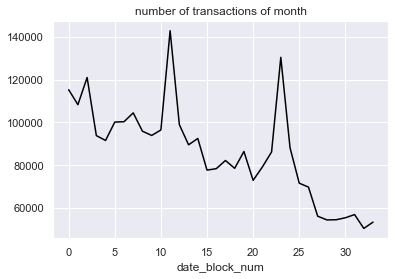

In [190]:
transactions = sales.groupby('date_block_num')['date'].count()
transactions

transactions.plot(title = 'number of transactions of month', color = 'black')

#전체적으로 월별 거래수가 꾸준히 하락함
#엄청 높게 치솟는 두 개 점은 연말(13년 12월, 14년 12월)임

In [177]:
#각 월 블록에서 매출 데이터에 거래가 있는 고유 상점 및 품목 수
shop_count = sales.groupby('date_block_num')['shop_id'].nunique()
item_count = sales.groupby('date_block_num')['item_id'].nunique()

sales.groupby('date_block_num').nunique()
#sales.groupby('date_block_num')['shop_id'].nunique() #월별 고유 상점수
#sales.groupby('date_block_num')['item_id'].nunique()  #d월별 고유 아이템수

sales['item_id'].nunique() #item 21802개
items['item_id'].nunique() #item 22170개
#sales['shop_id'].nunique() #shop 60개
shops['shop_id'].nunique() #shop 60개

#sales에 있는 item_id랑 items에 있는 item_id의 수가 다름

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
5,10.01.2013,0,25,2564,349.00,1.0


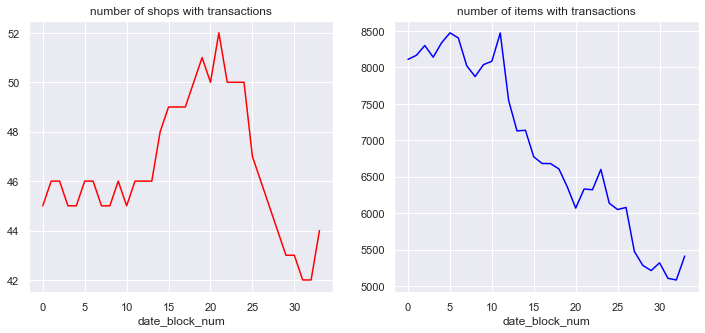

In [150]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
shop_count.plot(ax = ax[0], color = 'red')
item_count.plot(ax = ax[1], color = 'blue')
ax[0].set_title('number of shops with transactions') #거래가 있는 상점수
ax[1].set_title('number of items with transactions') #거래된 아이템수
plt.show()

In [ ]:
#연말을 제외하고는 월별 거래수와 월별 거래된 아이템수 모두 하락세
#거래처들의 수는 2년차부터는 느는 듯 했으나 2말부터 훅훅 떨어짐

#그리고 거래처수가 60개로 나오는데 차트를 보면 매달 모든 가게에서 거래되는 게 아니고
#물건도 많이 못미친다

In [178]:
test['shop_id'].nunique() #42개

42